In [ ]:
!nvidia-smi

Fri May  7 12:57:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## Ссылки:
* [Chris Olah's blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

Рекурретные нейросети нужны для работы с **последовательными данными** произвольной длины. Они представляют собой абстрактные ячейки, у которых есть какая-то **память** (hidden state), которая обновляется после обработки очередной порции данных.

Если в самом простом виде, то в рекуррентных сетках для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ — входной вектор на текущем шаге;
* $y(t)$ — выходной вектор на текущем шаге;
* $w_x$ — вектор весов нейронов для входа;
* $w_y$ — вектор весов нейронов для выхода;
* $y(t-1)$ — выходной вектор с прошлого шага (для первого шага этот вектор нулевой);
* $b$ — bias;
* $\phi$ — какая-то функция активации (например, ReLU).

Эту ячейку применяют по очереди ко всей последовательности, пробрасывая hidden state с предыдущего состояния. С точки зрения построения вычислительного графа это выглядит так:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

То есть если зафиксировать длину последовательности, то мы получим обычный фиксированный ациклический граф вычислений, в котором просто пошерены параметры всех ячеек.

### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в квадратных скобках — конкатенация матриц

По размерностям:
* $Y_{(t)}$ — матрица [$m$ x n_neurons]
* $X_{(t)}$ — матрица [$m$ x n_features]
* $b$ — вектор длины n_neurons
* $W_x$ — веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ — веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

**Disclaimer:** не используйте самописные RNN-ки в реальной жизни.

Давайте реализуем торчовый модуль, который это реализует.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.W = nn.Linear(input_size + hidden_size, hidden_size)
        self.T = nn.Tanh()
        # <создать Wx, Wy?>

    def forward(self, input_data, hidden):
        # <использовать Wx, Wy для полученния нового hidden>
        A = self.W.forward(torch.cat([input_data, hidden], 1))
        hidden = self.T(A)
        return hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [ ]:
input_feature_size = 6
hidden_size=5
batch_size=4

In [ ]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden(batch_size)

In [ ]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [ ]:
print(new_hidden.shape)

torch.Size([4, 5])


In [ ]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
new_hidden:  [[ 0.25575387 -0.25778443 -0.05177634 -0.53972244  0.13200852]
 [-0.07982241 -0.21517119 -0.04698005 -0.26717666  0.31181595]
 [ 0.23109661 -0.10783208 -0.03214293 -0.33932936  0.11132921]
 [ 0.29400006 -0.13074352  0.03723406 -0.32433534  0.20422246]]


In [ ]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[ 0.28972623 -0.44776922 -0.02408086 -0.48332176  0.06178619]
 [ 0.03084625 -0.32233468 -0.11816632 -0.16959076  0.33505616]
 [ 0.25310826 -0.25176656 -0.02570888 -0.31659326  0.06560036]
 [ 0.31592786 -0.28567663  0.04389407 -0.3119081   0.2030558 ]]


**Задание**. Модифицируйте код так, чтобы на вход можно было подавать батчи размером больше 1.

# Классификация картинок с RNN

Представьте, что у вас есть какая-то длинная картинка, в которой свёртки точно не зайдут. Например, снимки со спутника, спектрограмма или длиннокот.

Можно обработать их построчно с помощью рекуррентных сетей — просто подавать в качестве входа все пиксели очередной строки.

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [ ]:
!mkdir data

Загружаем данные

In [ ]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 128

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
!ls -lh data/

total 4.0K
drwxr-xr-x 4 root root 4.0K May  7 12:58 MNIST


Populating the interactive namespace from numpy and matplotlib


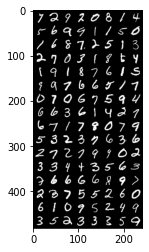

In [ ]:
%pylab inline
import numpy as np

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [ ]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 196
N_OUTPUTS = 10
N_EPOCHS = 12

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-0.0999,  0.1037, -0.1006, -0.0800,  0.0539,  0.0119,  0.0602,  0.0384,
         -0.0386, -0.0750],
        [-0.1075,  0.1094, -0.1162, -0.0814,  0.0449,  0.0227,  0.0473,  0.0420,
         -0.0448, -0.0787],
        [-0.0992,  0.1040, -0.1019, -0.0844,  0.0524,  0.0136,  0.0629,  0.0417,
         -0.0369, -0.0729],
        [-0.0972,  0.1022, -0.0965, -0.0776,  0.0496,  0.0135,  0.0585,  0.0428,
         -0.0335, -0.0715],
        [-0.0985,  0.0891, -0.0858, -0.0717,  0.0612,  0.0210,  0.0723,  0.0438,
         -0.0513, -0.0576],
        [-0.1210,  0.0976, -0.0924, -0.0674,  0.0511,  0.0299,  0.0591,  0.0516,
         -0.0594, -0.0689],
        [-0.1036,  0.0979, -0.0999, -0.0812,  0.0509,  0.0186,  0.0600,  0.0375,
         -0.0329, -0.0659],
        [-0.0798,  0.0969, -0.1230, -0.1021,  0.0671,  0.0065,  0.0764,  0.0214,
         -0.0229, -0.0671],
        [-0.1035,  0.1059, -0.1066, -0.0829,  0.0491,  0.0152,  0.0628,  0.0437,
         -0.0373, -0.0681],
        [-0.1029,  

## Обучаем

In [ ]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(N_EPOCHS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7644 | Train Accuracy: 75.24
Epoch:  1 | Loss: 0.3152 | Train Accuracy: 91.00
Epoch:  2 | Loss: 0.2252 | Train Accuracy: 93.65
Epoch:  3 | Loss: 0.1909 | Train Accuracy: 94.64
Epoch:  4 | Loss: 0.1554 | Train Accuracy: 95.71
Epoch:  5 | Loss: 0.1353 | Train Accuracy: 96.18
Epoch:  6 | Loss: 0.1285 | Train Accuracy: 96.42
Epoch:  7 | Loss: 0.1144 | Train Accuracy: 96.93
Epoch:  8 | Loss: 0.1058 | Train Accuracy: 97.04
Epoch:  9 | Loss: 0.1011 | Train Accuracy: 97.22
Epoch:  10 | Loss: 0.0979 | Train Accuracy: 97.35
Epoch:  11 | Loss: 0.0926 | Train Accuracy: 97.47


### Смотрим что на тесте

In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 97.41


# Сентимент анализ

Домашка — классифицировать отзывы с IMDB на положительный / отрицательный только по тексту.

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

Суть такая же, только нужно предобработать тексты — каждому слову сопоставить обучаемый вектор (embedding), который пойдёт дальше в RNN.

In [ ]:
# это уберет боль работы с текстами
!pip install torchtext
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


**Примечание.** Torchtext уже не очень живой проект, а в spacy нет русского.


In [ ]:
import torch
from torchtext.legacy import data

SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy', tokenizer_language = 'en_core_web_sm', include_lengths=True)
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:05<00:00, 16.0MB/s]


In [ ]:
ls -lh data/imdb/aclImdb/

total 1.7M
-rw-r--r-- 1 7297 1000 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 4.0K Jun 26  2011 README
drwxr-xr-x 4 7297 1000 4.0K Apr 12  2011 test/
drwxr-xr-x 5 7297 1000 4.0K Jun 26  2011 train/


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [ ]:
print(vars(train_data.examples[0]))

{'text': ['This', 'movie', 'has', 'several', 'things', 'going', 'for', 'it', '.', 'It', 'is', 'a', '"', 'feel', 'good', '"', 'story', '.', 'The', 'characters', 'and', 'actors', 'are', 'likable', ',', 'realistic', 'and', 'present', 'fine', 'performances', '.', 'Most', 'important', ',', 'I', 'believe', ',', 'is', 'that', 'Dennis', 'Quaid', 'knows', 'how', 'to', 'grip', 'and', 'throw', 'a', 'baseball', '.', 'Robert', 'Redford', 'looked', 'good', 'both', 'throwing', 'and', 'swinging', 'a', 'bat', 'in', '"', 'The', 'Natural', ',', 'and', 'so', 'did', 'Kevin', 'Costner', 'in', '"', 'For', 'Love', 'of', 'the', 'Game', '"', 'and', '"', 'Bull', 'Durham', '.', '"', 'In', '"', 'Major', 'League', ',', '"', 'Tom', 'Berenger', 'and', 'Charlie', 'Sheen', 'looked', 'like', 'they', 'knew', 'what', 'they', 'were', 'doing', ',', 'but', 'many', 'of', 'the', 'others', 'did', 'not', ',', 'and', 'that', 'picture', 'was', 'pure', 'silliness', '-', 'and', 'not', 'very', 'funny', '.', '<', 'br', '/><br', '/>So'

In [ ]:
# Сделаем еще eval
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [ ]:
# Сделаем словарь
TEXT.build_vocab(train_data, 
                 max_size = 25000, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.38MB/s]                          
100%|█████████▉| 398594/400000 [00:21<00:00, 18104.97it/s]

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [ ]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8737, 'pos': 8763}),
 'itos': ['pos', 'neg'],
 'stoi': defaultdict(None, {'neg': 1, 'pos': 0}),
 'unk_index': None,
 'vectors': None}

Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 204253), (',', 194379), ('.', 166881), ('and', 110273), ('a', 110107), ('of', 101699), ('to', 94338), ('is', 76710), ('in', 62213), ('I', 54488), ('it', 53993), ('that', 49501), ('"', 44962), ("'s", 44045), ('this', 42797), ('-', 37357), ('/><br', 35728), ('was', 34952), ('as', 30513), ('with', 30450)]


* stoi (string to int)
* itos (int to string)

In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'pos': 0, 'neg': 1})


In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# собираем батчи так, чтобы в каждом батче были примеры наиболее похожей длины
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    device=device)

## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)  

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)     
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))  
        
        return self.fc(hidden)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.9269,  1.4873,  0.9007,  ...,  0.1233,  0.3499,  0.6173],
        [ 0.7262,  0.0912, -0.3891,  ...,  0.0821,  0.4440, -0.7240],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.6863, -1.0150, -0.8819,  ...,  0.1242, -0.7969, -0.2534],
        [-1.6579, -1.3437,  3.0049,  ...,  1.7892,  0.7861, -0.2500],
        [-1.0848,  0.2415, -0.8205,  ..., -0.3608,  1.7414,  0.0798]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.6863, -1.0150, -0.8819,  ...,  0.1242, -0.7969, -0.2534],
        [-1.6579, -1.3437,  3.0049,  ...,  1.7892,  0.7861, -0.2500],
        [-1.0848,  0.2415, -0.8205,  ..., -0.3608,  1.7414,  0.0798]])


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

100%|█████████▉| 398594/400000 [00:40<00:00, 18104.97it/s]

In [ ]:
def accuracy(y_true, y_pred):
    rounded_preds = torch.round(torch.sigmoid(y_pred))
    correct = (rounded_preds == y_true).float()
    return correct.sum() / len(correct)

In [ ]:
N_EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0


    model.train()
    for train_data in train_iterator:
        optimizer.zero_grad()
        text, text_lengths = train_data.text
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, train_data.label)
        acc = accuracy(train_data.label, predictions)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_iterator)
    train_acc /= len(train_iterator)

    model.eval()
    with torch.no_grad():
        for valid_data in valid_iterator:
            text, text_lengths = valid_data.text
            predictions = model(text, text_lengths).squeeze(1)    
            loss = criterion(predictions, valid_data.label)
            acc = accuracy(valid_data.label, predictions)

            valid_loss += loss.item()
            valid_acc += acc.item()
    
    valid_loss /= len(valid_iterator)
    valid_acc /= len(valid_iterator)
      
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch {epoch}')
    print(f'\tTrain | Loss: {train_loss:.4f} | Accuracy: {train_acc*100:.2f}%') 
    print(f'\tValid | Loss: {valid_loss:.4f} | Accuracy: {valid_acc*100:.2f}%') 

Epoch 0
	Train | Loss: 0.5823 | Accuracy: 69.09%
	Valid | Loss: 0.6118 | Accuracy: 69.01%
Epoch 1
	Train | Loss: 0.5229 | Accuracy: 73.93%
	Valid | Loss: 0.4537 | Accuracy: 80.16%
Epoch 2
	Train | Loss: 0.4310 | Accuracy: 80.21%
	Valid | Loss: 0.4224 | Accuracy: 81.61%
Epoch 3
	Train | Loss: 0.3316 | Accuracy: 86.24%
	Valid | Loss: 0.2967 | Accuracy: 87.96%
Epoch 4
	Train | Loss: 0.2547 | Accuracy: 90.08%
	Valid | Loss: 0.3116 | Accuracy: 87.82%


In [ ]:
model.load_state_dict(torch.load('model.pt'))

test_loss = 0.0
test_acc = 0.0

model.eval()
with torch.no_grad():
    for test_data in test_iterator:
        text, text_lengths = test_data.text
        predictions = model(text, text_lengths).squeeze(1)    
        loss = criterion(predictions, test_data.label)
        acc = accuracy(test_data.label, predictions)

        test_loss += loss.item()
        test_acc += acc.item()

test_loss /= len(test_iterator)
test_acc /= len(test_iterator)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.309 | Test Acc: 86.97%
